In [1]:
using ITensors
using ITensorMPS
using LinearAlgebra
using Statistics
using Plots
using ProgressMeter
using Random
using GLM
using DataFrames

Random.seed!(42)

TaskLocalRNG()

In [2]:
println("Number of threads available: ", Threads.nthreads())
println("Thread pool size: ", Threads.threadpoolsize())

Number of threads available: 10
Thread pool size: 10


In [2]:
function create_plus_state_mps(L::Int)
    # It generates a list of site indices for a quantum system of L sites, where each site has spin-1/2
    
    sites = siteinds("S=1/2", L)
    
    # Create product state |+⟩^⊗L where |+⟩ = (|↑⟩ + |↓⟩)/√2
    # ITensors notation for |+⟩ state
    state = ["+" for _ in 1:L]
    ψ = productMPS(sites, state)
    
    return ψ, sites
end

create_plus_state_mps (generic function with 1 method)

In [3]:
function apply_single_site_gate(ψ::MPS, site::Int, gate::ITensor; 
                                maxdim::Int=128, cutoff::Float64=1e-12)
    ψ_new = copy(ψ)
    ψ_new[site] = gate * ψ_new[site]
    noprime!(ψ_new[site])  # Remove prime indices for consistency

    if maxlinkdim(ψ_new) > maxdim
        ψ_new = truncate(ψ_new; maxdim=maxdim, cutoff=cutoff)
    end
    
    return ψ_new
end

function apply_two_site_gate(ψ::MPS, site1::Int, site2::Int, gate::ITensor; 
                            maxdim::Int=128, cutoff::Float64=1e-12)
    if abs(site1 - site2) == 1
        s1, s2 = min(site1, site2), max(site1, site2)
        return product(gate, ψ, [s1, s2]; maxdim=maxdim, cutoff=cutoff)
    else
        return ψ  # No operation for non-adjacent sites
    end
end

apply_two_site_gate (generic function with 1 method)

In [4]:
function calculate_entropy(ψ::MPS, cut::Int)
    L = length(ψ)
    if cut <= 0 || cut >= L
        return 0.0  # Boundary conditions: no entanglement across trivial cuts
    end
    
    try
        # Create copy and move orthogonality center to cut position
        # This ensures proper Schmidt decomposition across the cut
        ψ_copy = copy(ψ)
        orthogonalize!(ψ_copy, cut)
        
        # Get bond between sites cut and cut+1
        if cut < L
            bond_idx = commonind(ψ_copy[cut], ψ_copy[cut+1])
            if bond_idx !== nothing
                # Perform singular value decomposition: M = USV†
                # Schmidt values are the singular values
                U, S, V = svd(ψ_copy[cut], (bond_idx,))
                
                # Extract Schmidt values (singular values)
                schmidt_vals = Float64[]
                for i in 1:dim(S, 1)
                    val = S[i,i]
                    if abs(val) > 1e-12  # Numerical cutoff
                        push!(schmidt_vals, abs(val))
                    end
                end
                
                if isempty(schmidt_vals)
                    return 0.0
                end
                
                # Normalize Schmidt values (should already be normalized, but ensure)
                schmidt_vals = schmidt_vals ./ norm(schmidt_vals)
                
                # Calculate von Neumann entropy: S = -Σ λᵢ log₂(λᵢ)
                # where λᵢ = (Schmidt value)² are the Schmidt coefficients
                entropy = -sum(s^2 * log2(s^2 + 1e-16) for s in schmidt_vals)
                return entropy
            end
        end
        
        return 0.0
    catch e
        println("Warning: Entropy calculation failed for cut=$cut: $e")
        return 0.0
    end
end

calculate_entropy (generic function with 1 method)

In [5]:
function create_weak_measurement_operators(sites, lambda_x::Float64, lambda_zz::Float64)
    # Weak X measurement Kraus operators for outcomes 0 and 1
    WEAK_X_0 = Dict()
    WEAK_X_1 = Dict()
    
    # Weak ZZ measurement Kraus operators for outcomes 0 and 1  
    WEAK_ZZ_0 = Dict()
    WEAK_ZZ_1 = Dict()
    
    # Normalization factors
    norm_x = sqrt(2 * (1 + lambda_x^2))
    norm_zz = sqrt(2 * (1 + lambda_zz^2))
    
    # Create weak X operators for each site
    for i in 1:length(sites)
        Id_i = op("Id", sites[i])
        X_i = op("X", sites[i])
        
        # K_0 = (I + λ_x X) / √(2(1 + λ_x²))
        WEAK_X_0[i] = (Id_i + lambda_x * X_i) / norm_x
        # K_1 = (I - λ_x X) / √(2(1 + λ_x²))  
        WEAK_X_1[i] = (Id_i - lambda_x * X_i) / norm_x
    end
    
    # Create weak ZZ operators for adjacent pairs
    for i in 1:(length(sites)-1)
        Z_i = op("Z", sites[i])
        Z_j = op("Z", sites[i+1])
        Id_i = op("Id", sites[i])
        Id_j = op("Id", sites[i+1])
        
        ZZ = Z_i * Z_j
        II = Id_i * Id_j
        
        # K_0 = (II + λ_zz ZZ) / √(2(1 + λ_zz²))
        WEAK_ZZ_0[(i, i+1)] = (II + lambda_zz * ZZ) / norm_zz
        # K_1 = (II - λ_zz ZZ) / √(2(1 + λ_zz²))
        WEAK_ZZ_1[(i, i+1)] = (II - lambda_zz * ZZ) / norm_zz
    end
    
    return WEAK_X_0, WEAK_X_1, WEAK_ZZ_0, WEAK_ZZ_1
end

create_weak_measurement_operators (generic function with 1 method)

In [6]:
function apply_weak_x_measurement(ψ::MPS, site::Int, prob::Float64,
                                 WEAK_X_0::Dict, WEAK_X_1::Dict;
                                 maxdim::Int=128, cutoff::Float64=1e-12)
    # Skip measurement with probability (1-prob)
    if rand() >= prob
        return ψ
    end
    
    ψ_0 = apply_single_site_gate(ψ, site, WEAK_X_0[site]; maxdim=maxdim, cutoff=cutoff)
    ψ_1 = apply_single_site_gate(ψ, site, WEAK_X_1[site]; maxdim=maxdim, cutoff=cutoff)
    
    prob_0 = real(inner(ψ_0, ψ_0))
    prob_1 = real(inner(ψ_1, ψ_1))
    
    # Ensure non-negative probabilities
    prob_0 = max(prob_0, 0.0)
    prob_1 = max(prob_1, 0.0)
    total_prob = prob_0 + prob_1
    
    # Handle edge case
    if total_prob < 1e-12
        return nothing
    end
    
    # Normalize probabilities
    prob_0 /= total_prob
    prob_1 /= total_prob
    
    # Randomly choose outcome based on quantum probabilities
    if rand() < prob_0
        if prob_0 < 1e-12
            return nothing
        end
        normalize!(ψ_0)
        return ψ_0
    else
        if prob_1 < 1e-12
            return nothing
        end
        normalize!(ψ_1)
        return ψ_1
    end
end

function apply_weak_zz_measurement(ψ::MPS, site1::Int, site2::Int, prob::Float64,
                                  WEAK_ZZ_0::Dict, WEAK_ZZ_1::Dict;
                                  maxdim::Int=128, cutoff::Float64=1e-12)
    # Skip measurement with probability (1-prob)
    if rand() >= prob
        return ψ
    end
    
    # Apply operators
    ψ_0 = apply_two_site_gate(ψ, site1, site2, WEAK_ZZ_0[(site1, site2)]; 
                             maxdim=maxdim, cutoff=cutoff)
    ψ_1 = apply_two_site_gate(ψ, site1, site2, WEAK_ZZ_1[(site1, site2)]; 
                             maxdim=maxdim, cutoff=cutoff)
    
    # Calculate probabilities
    prob_0 = real(inner(ψ_0, ψ_0))
    prob_1 = real(inner(ψ_1, ψ_1))
    
    prob_0 = max(prob_0, 0.0)
    prob_1 = max(prob_1, 0.0)
    total_prob = prob_0 + prob_1
    
    if total_prob < 1e-12
        return nothing
    end
    
    # Normalize and choose outcome
    prob_0 /= total_prob
    prob_1 /= total_prob
    
    if rand() < prob_0
        if prob_0 < 1e-12
            return nothing
        end
        normalize!(ψ_0)
        return ψ_0
    else
        if prob_1 < 1e-12
            return nothing
        end
        normalize!(ψ_1)
        return ψ_1
    end
end

apply_weak_zz_measurement (generic function with 1 method)

In [7]:
function run_single_trial_weak(seed::Int, L::Int, T_max::Int, lambda_x::Float64, lambda_zz::Float64, 
                              cuts::Vector{Int}; maxdim::Int=128, cutoff::Float64=1e-12, 
                              periodic::Bool=false)

    Random.seed!(seed)
    
    ψ, sites = create_plus_state_mps(L)
    
    WEAK_X_0, WEAK_X_1, WEAK_ZZ_0, WEAK_ZZ_1 = create_weak_measurement_operators(sites, lambda_x, lambda_zz)
    
    for t in 1:T_max
        # Apply weak X measurements on all sites
        for i in 1:L
            ψ = apply_weak_x_measurement(ψ, i, 1.0, WEAK_X_0, WEAK_X_1; 
                                        maxdim=maxdim, cutoff=cutoff)
            if ψ === nothing
                return fill(NaN, length(cuts))
            end
        end
        
        # Apply weak ZZ measurements on adjacent pairs
        for i in 1:(L-1)
            ψ = apply_weak_zz_measurement(ψ, i, i+1, 1.0, WEAK_ZZ_0, WEAK_ZZ_1;
                                         maxdim=maxdim, cutoff=cutoff)
            if ψ === nothing
                return fill(NaN, length(cuts))
            end
        end
        
        if periodic && L > 2
            # no loop
        end
    end
    
    entropies = [calculate_entropy(ψ, cut) for cut in cuts]
    return entropies
end

run_single_trial_weak (generic function with 1 method)

In [8]:
function run_parallel_simulation_weak(L::Int, T_max::Int, lambda_x::Float64, lambda_zz::Float64, 
                                      cuts::Vector{Int}, num_trials::Int; seed::Int=42, 
                                      maxdim::Int=128, cutoff::Float64=1e-12, periodic::Bool=false)

    seeds = [seed + i for i in 0:(num_trials-1)]
    all_results = Vector{Vector{Float64}}(undef, num_trials)
    
    println("Running $(num_trials) weak measurement trials on $(Threads.nthreads()) threads...")
    println("Parameters: λ_x = $lambda_x, λ_zz = $lambda_zz, periodic = $periodic")
    
    # Run trials in parallel
    @showprogress desc="Weak measurement simulation: " Threads.@threads for idx in 1:num_trials
        all_results[idx] = run_single_trial_weak(seeds[idx], L, T_max, lambda_x, lambda_zz, cuts; 
                                                 maxdim=maxdim, cutoff=cutoff, periodic=periodic)
    end
    
    # Compute averages and standard errors
    results_matrix = hcat(all_results...)'
    avg_entropies = Float64[]
    std_errors = Float64[]
    
    for i in 1:length(cuts)
        valid_results = filter(!isnan, results_matrix[:, i])
        if !isempty(valid_results)
            push!(avg_entropies, mean(valid_results))
            push!(std_errors, std(valid_results) / sqrt(length(valid_results)))
        else
            push!(avg_entropies, NaN)
            push!(std_errors, NaN)
        end
    end
    
    return avg_entropies, std_errors
end

run_parallel_simulation_weak (generic function with 1 method)

In [9]:
function analyze_weak_entanglement_scaling(L::Int, T_max::Int, lambda_x::Float64, lambda_zz::Float64, 
                                          num_trials::Int; seed::Int=42, maxdim::Int=128, 
                                          cutoff::Float64=1e-12, show_error_bars::Bool=true,
                                          periodic::Bool=false)

    cuts = collect(0:L)
    
    # Run simulation
    println("Analyzing weak measurement entanglement scaling:")
    println("L=$L, T_max=$T_max, λ_x=$lambda_x, λ_zz=$lambda_zz")
    
    avg_entropies, std_errors = run_parallel_simulation_weak(L, T_max, lambda_x, lambda_zz, 
                                                            cuts, num_trials; 
                                                            seed=seed, maxdim=maxdim, 
                                                            cutoff=cutoff, periodic=periodic)
    
    # Plot entropy vs cut size
    x_values = Float64.(cuts)
    if show_error_bars && !all(isnan.(std_errors))
        p1 = plot(x_values, avg_entropies, yerror=std_errors, marker=:circle, 
                 label="Weak measurement data", markersize=4, linewidth=2)
    else
        p1 = plot(x_values, avg_entropies, marker=:circle, label="Weak measurement data", 
                 markersize=4, linewidth=2)
    end
    
    xlabel!("Cut position ℓ")
    ylabel!("Entanglement entropy S(ℓ)")
    boundary_type = periodic ? "periodic" : "open"
    title!("Weak Measurement Entanglement Entropy\n(L=$L, λₓ=$lambda_x, λ_zz=$lambda_zz, $boundary_type, $(num_trials) trials)")
    plot!(grid=true, gridwidth=1, gridcolor=:lightgray, gridalpha=0.5)
    plot!(size=(800, 600), margin=5Plots.mm)
    display(p1)
    
    # CFT scaling analysis (exclude boundary cuts)
    inner_cuts = cuts[2:end-1]
    inner_entropies = avg_entropies[2:end-1]
    
    # Filter out NaN values
    valid_idx = findall(!isnan, inner_entropies)
    if length(valid_idx) > 3
        valid_cuts = inner_cuts[valid_idx]
        valid_entropies = inner_entropies[valid_idx]
        
        # Transform to conformal field theory scaling variable
        x_cft = log.((L / π) .* sin.(π .* Float64.(valid_cuts) ./ L))
        
        # Linear regression
        data = DataFrame(x=x_cft, y=valid_entropies)
        model = lm(@formula(y ~ x), data)
        slope = coef(model)[2]
        intercept = coef(model)[1]
        r_squared = r2(model)
        
        # Plot regression
        p2 = plot(x_cft, valid_entropies, marker=:circle, label="Data", markersize=4)
        plot!(x_cft, slope .* x_cft .+ intercept, linestyle=:dash, linewidth=2,
              label="Linear fit (slope=$(round(slope, digits=3)), R²=$(round(r_squared, digits=3)))")
        xlabel!("log(L/π × sin(π×ℓ/L))")
        ylabel!("Entanglement entropy S(ℓ)")
        title!("Weak Measurement CFT Scaling Analysis\n(Central charge c ≈ 6 × slope)")
        plot!(grid=true, gridwidth=1, gridcolor=:lightgray, gridalpha=0.5)
        plot!(size=(800, 600), margin=5Plots.mm)
        display(p2)
        
        # Calculate effective central charge
        c_eff = 6 * slope
        
        return avg_entropies, std_errors, slope, r_squared, c_eff
    else
        println("Warning: Not enough valid data points for regression analysis")
        return avg_entropies, std_errors, NaN, NaN, NaN
    end
end

analyze_weak_entanglement_scaling (generic function with 1 method)

Analyzing weak measurement entanglement scaling:
L=20, T_max=25, λ_x=0.5, λ_zz=0.5
Running 100 weak measurement trials on 10 threads...
Parameters: λ_x = 0.5, λ_zz = 0.5, periodic = false


Weak measurement simulation: 100%|██████████████████████| Time: 0:01:05


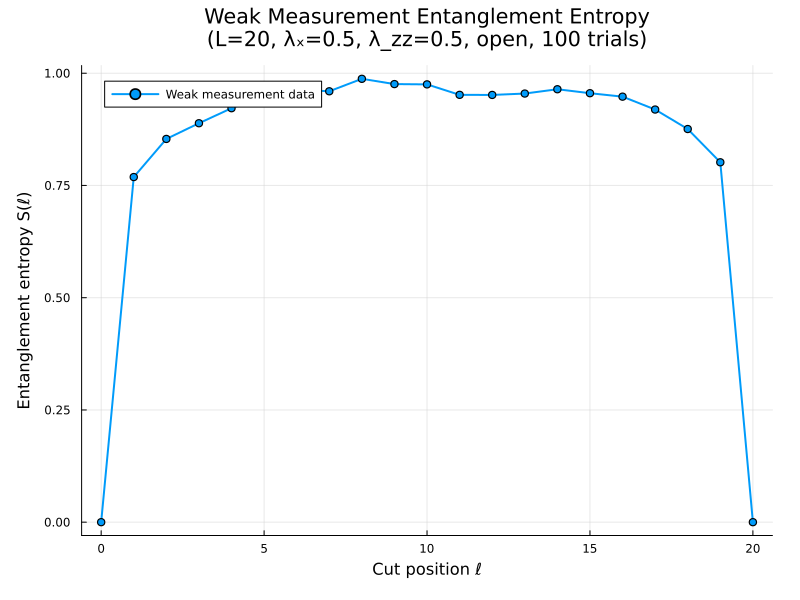

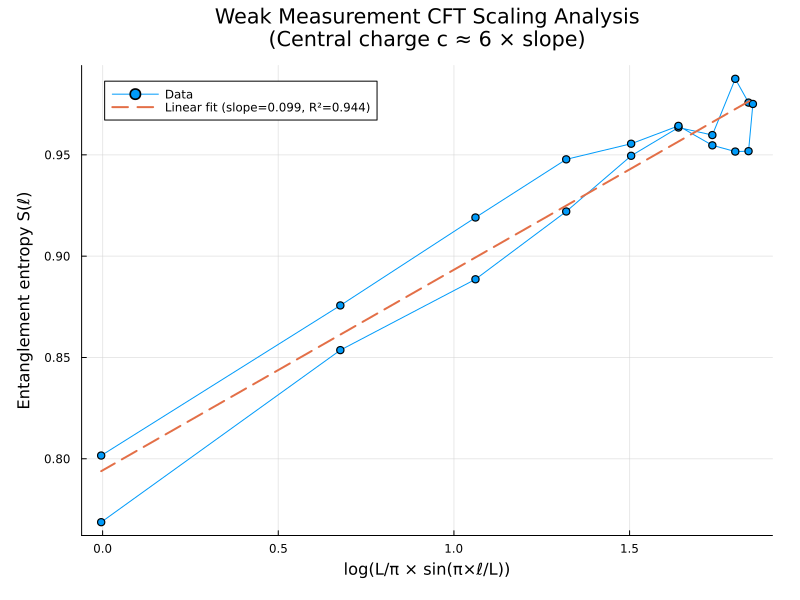

 70.392929 seconds (1.30 G allocations: 431.444 GiB, 33.07% gc time, 4 lock conflicts, 206.02% compilation time: <1% of which was recompilation)


([0.0, 0.7687212044100162, 0.8536296873141221, 0.8885907317816246, 0.9220417628514264, 0.9495259787539537, 0.9634922290106535, 0.9597551877273961, 0.987517346087883, 0.9757847044700095  …  0.9518097507579212, 0.9516208766865404, 0.9546882294138962, 0.9642875727793715, 0.9554828205234845, 0.9477786395587638, 0.9190793429173341, 0.8756819227147843, 0.8016060763680106, 0.0], [0.0, 0.01576124567557191, 0.014318918336279851, 0.017092893973080406, 0.01761115282385688, 0.022577168166688838, 0.022851320364550204, 0.02373110946607287, 0.021694752941825986, 0.02324799264529871  …  0.020948369116605615, 0.022156990306833935, 0.020717036515765952, 0.018741948751314432, 0.021598103679785423, 0.02226533966576481, 0.019962403181782308, 0.01948712831435171, 0.01567489696199573, 0.0], 0.09899569625723359, 0.9435749938701972, 0.5939741775434015)

In [10]:
L = 20
T_max = 60         
lambda_x = 0.5     
lambda_zz = 0.5    
num_trials = 100    
seed = 42          

@time begin
    avg_entropies, std_errors, slope, r_squared, c_eff = analyze_weak_entanglement_scaling(
        L, T_max, lambda_x, lambda_zz, num_trials;
        seed=seed,
        maxdim=64,              # Maximum bond dimension for MPS truncation
        cutoff=1e-12,           # SVD cutoff for truncation  
        show_error_bars=false,  # Show error bars in plots
        periodic=false          # Use open boundary conditions
    )
end

In [14]:
function simple_entropy_evolution(L_values::Vector{Int}, T_max::Int, lambda_x::Float64, lambda_zz::Float64; 
                                 num_trials::Int=5, sample_every::Int=5)
    """
    Show how entropy evolves as simulation runs longer (up to T_max)
    """
    
    colors = [:blue, :red, :green, :orange, :purple]
    
    # Time points to sample
    T_points = collect(sample_every:sample_every:T_max)
    
    # Initialize plot
    p = plot(title="Weak Measurement Entropy Evolution (T_max = $T_max)", 
             xlabel="Simulation Time (T)", 
             ylabel="Entanglement Entropy", 
             grid=true, gridwidth=1, gridcolor=:lightgray, gridalpha=0.5,
             size=(1000, 600), margin=5Plots.mm, legend=:bottomright)
    
    for (idx, L) in enumerate(L_values)
        println("Processing L = $L...")
        
        target_cut = div(L, 2)  # Middle cut
        entropies = Float64[]
        
        for T in T_points
            print("  T=$T... ")
            
            # Run a few trials for this time point
            trial_results = Float64[]
            for trial in 1:num_trials
                result = run_single_trial_weak(42 + trial, L, T, lambda_x, lambda_zz, [target_cut];
                                        maxdim=32, cutoff=1e-10)
                if !isnan(result[1])
                    push!(trial_results, result[1])
                end
            end
            
            if !isempty(trial_results)
                avg_S = mean(trial_results)
                push!(entropies, avg_S)
                println("S = $(round(avg_S, digits=3))")
            else
                push!(entropies, NaN)
                println("Failed")
            end
        end
        
        # Add to plot
        valid_indices = findall(!isnan, entropies)
        if !isempty(valid_indices)
            color = colors[mod(idx-1, length(colors)) + 1]
            
            plot!(p, T_points[valid_indices], entropies[valid_indices], 
                  marker=:circle, markersize=3, linewidth=2, 
                  color=color, label="L=$L",
                  markerstrokewidth=1, markerstrokecolor=color)
        end
    end
    
    display(p)
    return p
end

# Parameters
L_values = [8, 16, 20, 24, 30]  # System sizes
T_max = 100                     # Maximum simulation time
lambda_x = 0.5                  # Weak X measurement strength
lambda_zz = 0.5                 # Weak ZZ measurement strength
sample_every = 5                # Sample entropy every 5 time steps
num_trials = 5                  # Trials per point (for speed)

@time evolution_plot = simple_entropy_evolution(L_values, T_max, lambda_x, lambda_zz; 
                                               num_trials=num_trials, 
                                               sample_every=sample_every)

Processing L = 8...
  T=5... S = 0.805  T=5... S = 0.805
  T=10... S = 0.843

  T=10... S = 0.843
  T=15... S = 0.772  T=15... S = 0.772
  T=20... S = 0.705

  T=20... S = 0.705
  T=25... S = 0.876  T=25... S = 0.876
  T=30... S = 0.883

  T=30... S = 0.883
  T=35... S = 0.945  T=35... S = 0.945
  T=40... S = 0.868

  T=40... S = 0.868
  T=45... S = 0.994  T=45... S = 0.994
  T=50... S = 0.863

  T=50... S = 0.863
  T=55... S = 0.845  T=55... S = 0.845
  T=60... S = 0.912

  T=60... S = 0.912
  T=65... S = 0.789  T=65... S = 0.789
  T=70... S = 0.945

  T=70... S = 0.945
  T=75... S = 0.831  T=75... S = 0.831
  T=80... S = 0.936

  T=80... S = 0.936
  T=85... S = 0.824  T=85... S = 0.824
  T=90... S = 0.991

  T=90... S = 0.991
  T=95... S = 0.816
  T=100... S = 0.894
  T=95... S = 0.816
  T=100... S = 0.894
Processing L = 16...
  T=5... S = 1.018Processing L = 16...
  T=5... S = 1.018
  T=10... S = 0.975

  T=10... S = 0.975
  T=15... S = 0.904  T=15... S = 0.904
  T=20... S = 0.952



InterruptException: InterruptException:

In [ ]:
function calculate_magnetization_moments(ψ::MPS, sites)
    # m = (1/L) Σi ⟨Zi⟩ 
    # all spins aligned => m = +-1
    # disordered state => m = 0

    L = length(ψ)
    total_magnetization = 0.0
    for i in 1:L
        zi_expect = real(expect(ψ, "Z"; sites=i))
        total_magnetization += zi_expect
    end
    
    m = total_magnetization / L
    m2 = m^2
    m4 = m^4
    
    return m2, m4
end

function calculate_chi_susceptibility(ψ::MPS, sites)
    # χ = (1/L) Σij ⟨ZiZj⟩²
    L = length(ψ)
    
    try
        corr_matrix = correlation_matrix(ψ, "Z", "Z")
        
        chi = sum(abs2.(corr_matrix)) / L
        
        return real(chi)
        
    catch e
        println("Warning: Correlation matrix χ calculation failed: $e")
        return
    end
end



function run_single_trial_with_observables(seed::Int, L::Int, T_max::Int, lambda_x::Float64, lambda_zz::Float64; 
                                         maxdim::Int=64, cutoff::Float64=1e-12)
    # Higher λₓ/λ_zz ratio causes faster decoherence.
    Random.seed!(seed)
    
    # Start with ordered |↑↑↑...⟩
    sites = siteinds("S=1/2", L)
    state = ["Up" for _ in 1:L]
    ψ = productMPS(sites, state)
    
    WEAK_X_0, WEAK_X_1, WEAK_ZZ_0, WEAK_ZZ_1 = create_weak_measurement_operators(sites, lambda_x, lambda_zz)
    
    for t in 1:T_max
        # weak X measurements destroy Z order
        for i in 1:L
            ψ = apply_weak_x_measurement(ψ, i, 1.0, WEAK_X_0, WEAK_X_1; 
                                        maxdim=maxdim, cutoff=cutoff)
            if ψ === nothing
                return NaN, NaN, NaN
            end
        end
        
        # weak ZZ measurements try to preserve Z correlations
        for i in 1:(L-1)
            ψ = apply_weak_zz_measurement(ψ, i, i+1, 1.0, WEAK_ZZ_0, WEAK_ZZ_1;
                                         maxdim=maxdim, cutoff=cutoff)
            if ψ === nothing
                return NaN, NaN, NaN
            end
        end
    end
    
    # Calculate final observables
    m2, m4 = calculate_magnetization_moments(ψ, sites)
    chi = calculate_chi_susceptibility(ψ, sites)
    
    return m2, m4, chi
end

function analyze_binder_cumulant_fixed(L::Int, T_max::Int, lambda_ratios::Vector{Float64}, 
                                      lambda_zz_fixed::Float64, num_trials::Int; 
                                      seed::Int=42, maxdim::Int=64)
    
    # B = 1 - ⟨m⁴⟩/(3⟨m²⟩²)
    binder_results = Float64[]
    chi_results = Float64[]
    mean_m2_results = Float64[]
    
    println("Proper Binder Cumulant Analysis...")
    println("L=$L, T_max=$T_max, λ_zz=$lambda_zz_fixed, trials=$num_trials")
    
    @showprogress desc="Binder analysis: " for ratio in lambda_ratios
        lambda_x = ratio * lambda_zz_fixed
        
        # Collect magnetization data from trials
        m2_samples = Float64[]
        m4_samples = Float64[]
        chi_samples = Float64[]
        
        for trial in 1:num_trials
            m2, m4, chi = run_single_trial_with_observables(seed + trial, L, T_max, 
                                                          lambda_x, lambda_zz_fixed; 
                                                          maxdim=maxdim)
            if !isnan(m2) && !isnan(m4) && !isnan(chi)
                push!(m2_samples, m2)
                push!(m4_samples, m4)
                push!(chi_samples, chi)
            end
        end
        
        if !isempty(m2_samples)
            # Calculate ensemble averages
            avg_m2 = mean(m2_samples)
            avg_chi = mean(chi_samples)
            
            # Proper Binder cumulant: B = 1 - ⟨m⁴⟩/(3⟨m²⟩²)
            avg_m4 = mean(m4_samples)
            
            if avg_m2 > 1e-10                
                B = 1.0 - avg_m4 / (3.0 * avg_m2^2)
                
                # Clamp to physical range [0, 1]
                B = max(0.0, min(1.0, B))
            else
                # When magnetization is zero, system is completely disordered
                B = 1.0
            end
            
            push!(binder_results, B)
            push!(chi_results, avg_chi)
            push!(mean_m2_results, avg_m2)
            
            println("  λₓ/λ_zz=$(round(ratio, digits=2)): ⟨m²⟩=$(round(avg_m2, digits=4)), B=$(round(B, digits=4)), χ=$(round(avg_chi, digits=4))")
        else
            push!(binder_results, NaN)
            push!(chi_results, NaN)
            push!(mean_m2_results, NaN)
            println("  λₓ/λ_zz=$(round(ratio, digits=2)): Failed")
        end
    end
    
    return binder_results, chi_results, mean_m2_results
end


analyze_binder_cumulant_fixed (generic function with 1 method)

In [ ]:
function analyze_multiple_system_sizes(L_values::Vector{Int}, T_max::Int, lambda_ratios::Vector{Float64}, 
                                      lambda_zz_fixed::Float64, num_trials::Int; 
                                      seed::Int=42, maxdim::Int=64)
    println("System sizes: $L_values")
    println("T_max=$T_max, λ_zz=$lambda_zz_fixed, trials=$num_trials")
    
    # Storage for all results
    all_binder_results = Dict{Int, Vector{Float64}}()
    all_chi_results = Dict{Int, Vector{Float64}}()
    all_m2_results = Dict{Int, Vector{Float64}}()
    
    # Run analysis for each system size
    for L in L_values
        println("\n--- Processing L = $L ---")
        
        binder_data, chi_data, m2_data = analyze_binder_cumulant_fixed(
            L, T_max, lambda_ratios, lambda_zz_fixed, num_trials; 
            seed=seed, maxdim=maxdim)
        
        all_binder_results[L] = binder_data
        all_chi_results[L] = chi_data
        all_m2_results[L] = m2_data
    end
    
    return all_binder_results, all_chi_results, all_m2_results
end

function plot_multiple_system_sizes(lambda_ratios::Vector{Float64}, 
                                   all_binder_results::Dict{Int, Vector{Float64}},
                                   all_chi_results::Dict{Int, Vector{Float64}},
                                   L_values::Vector{Int}, lambda_zz_fixed::Float64)    
    colors = [:blue, :red, :green, :orange, :purple, :brown]
    
    # Plot 1: Binder cumulant for all system sizes
    p1 = plot(title="Disorder Parameter vs λₓ/λ_zz Ratio\n(λ_zz=$lambda_zz_fixed, Multiple System Sizes)",
              xlabel="λₓ/λ_zz", ylabel="Disorder Parameter B",
              grid=true, gridwidth=1, gridcolor=:lightgray, gridalpha=0.5,
              size=(900, 700), margin=5Plots.mm, legend=:bottomright)
    
    for (idx, L) in enumerate(L_values)
        binder_data = all_binder_results[L]
        
        # Filter out NaN values
        valid_indices = findall(x -> !isnan(x), binder_data)
        valid_ratios = lambda_ratios[valid_indices]
        valid_binder = binder_data[valid_indices]
        
        if !isempty(valid_binder)
            color = colors[mod(idx-1, length(colors)) + 1]
            plot!(p1, valid_ratios, valid_binder, 
                  marker=:circle, markersize=5, linewidth=2,
                  color=color, label="L=$L",
                  markerstrokewidth=1, markerstrokecolor=color)
        end
    end
    
    hline!(p1, [0.0], linestyle=:dash, color=:gray, alpha=0.5, label="B = 0 (ordered)")
    hline!(p1, [1.0], linestyle=:dash, color=:black, alpha=0.5, label="B = 1 (disordered)")
    
    # Plot 2: Chi susceptibility for all system sizes  
    p2 = plot(title="ZZ Correlation Susceptibility vs λₓ/λ_zz Ratio\n(λ_zz=$lambda_zz_fixed, Multiple System Sizes)",
              xlabel="λₓ/λ_zz", ylabel="χ = (1/L)Σᵢⱼ⟨ZᵢZⱼ⟩²",
              grid=true, gridwidth=1, gridcolor=:lightgray, gridalpha=0.5,
              size=(900, 700), margin=5Plots.mm, legend=:topright)
    
    for (idx, L) in enumerate(L_values)
        chi_data = all_chi_results[L]
        
        # Filter out NaN values
        valid_indices = findall(x -> !isnan(x), chi_data)
        valid_ratios = lambda_ratios[valid_indices]
        valid_chi = chi_data[valid_indices]
        
        if !isempty(valid_chi)
            color = colors[mod(idx-1, length(colors)) + 1]
            plot!(p2, valid_ratios, valid_chi,
                  marker=:circle, markersize=5, linewidth=2,
                  color=color, label="L=$L",
                  markerstrokewidth=1, markerstrokecolor=color)
        end
    end
    
    return p1, p2
end


function run_multi_size_analysis()

    L_values = [10, 20]
    T_max = 50                                     
    lambda_zz_fixed = 0.3                        
    lambda_ratios = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2.0]
    num_trials = 100                               
    
    println("Running analysis for system sizes: $L_values")
    
    # Run analysis for all system sizes
    @time begin
        all_binder_results, all_chi_results, all_m2_results = analyze_multiple_system_sizes(
            L_values, T_max, lambda_ratios, lambda_zz_fixed, num_trials; 
            seed=42, maxdim=32)
    end
    
    # Create combined plots (without displaying them)
    p1, p2 = plot_multiple_system_sizes(lambda_ratios, all_binder_results, all_chi_results, 
                                       L_values, lambda_zz_fixed)
    
    return all_binder_results, all_chi_results, all_m2_results, p1, p2
end

all_binder_data, all_chi_data, all_m2_data, plot1, plot2 = run_multi_size_analysis()

Running analysis for system sizes: [10, 20]
=== Multi-Size Binder Cumulant and Chi Analysis ===
System sizes: [10, 20]
T_max=50, λ_zz=0.3, trials=100

--- Processing L = 10 ---
Proper Binder Cumulant Analysis...
L=10, T_max=50, λ_zz=0.3, trials=100
Expected: B goes from 0 (ordered) to 2/3 (disordered)
Critical crossing: All L should cross at B_c ≈ 0.61
  λₓ/λ_zz=0.01: ⟨m²⟩=0.9926, B=0.0074, χ=9.9969
  λₓ/λ_zz=0.05: ⟨m²⟩=0.9399, B=0.0601, χ=9.8853


Binder analysis:  14%|████▉                             |  ETA: 0:10:22

  λₓ/λ_zz=0.1: ⟨m²⟩=0.8363, B=0.1637, χ=9.6758


Binder analysis:  21%|███████▎                          |  ETA: 0:09:12

  λₓ/λ_zz=0.2: ⟨m²⟩=0.5094, B=0.4906, χ=9.0569


Binder analysis:  29%|█████████▊                        |  ETA: 0:08:15

  λₓ/λ_zz=0.3: ⟨m²⟩=0.2367, B=0.7633, χ=8.0839


Binder analysis:  36%|████████████▏                     |  ETA: 0:07:22

  λₓ/λ_zz=0.4: ⟨m²⟩=0.1442, B=0.8558, χ=6.8335


Binder analysis:  43%|██████████████▋                   |  ETA: 0:06:32

  λₓ/λ_zz=0.5: ⟨m²⟩=0.0697, B=0.9303, χ=5.4364


Binder analysis:  50%|█████████████████                 |  ETA: 0:05:43

  λₓ/λ_zz=0.6: ⟨m²⟩=0.0541, B=0.9459, χ=4.1568


Binder analysis:  57%|███████████████████▍              |  ETA: 0:04:54

  λₓ/λ_zz=0.7: ⟨m²⟩=0.043, B=0.957, χ=2.0967


Binder analysis:  64%|█████████████████████▉            |  ETA: 0:04:06

  λₓ/λ_zz=0.8: ⟨m²⟩=0.0314, B=0.9686, χ=1.3101


Binder analysis:  71%|████████████████████████▎         |  ETA: 0:03:17

  λₓ/λ_zz=0.9: ⟨m²⟩=0.0204, B=0.9796, χ=0.6636


Binder analysis:  79%|██████████████████████████▊       |  ETA: 0:02:27

  λₓ/λ_zz=1.0: ⟨m²⟩=0.0071, B=0.9929, χ=0.2067


Binder analysis:  86%|█████████████████████████████▏    |  ETA: 0:01:38

  λₓ/λ_zz=1.5: ⟨m²⟩=0.0, B=1.0, χ=0.0


Binder analysis:  93%|███████████████████████████████▋  |  ETA: 0:00:49

  λₓ/λ_zz=2.0: ⟨m²⟩=0.0, B=1.0, χ=0.0


Binder analysis: 100%|██████████████████████████████████| Time: 0:11:25



--- Processing L = 20 ---
Proper Binder Cumulant Analysis...
L=20, T_max=50, λ_zz=0.3, trials=100
Expected: B goes from 0 (ordered) to 2/3 (disordered)
Critical crossing: All L should cross at B_c ≈ 0.61
  λₓ/λ_zz=0.01: ⟨m²⟩=0.9998, B=0.0002, χ=19.9919
  λₓ/λ_zz=0.05: ⟨m²⟩=0.9567, B=0.0433, χ=19.7947


Binder analysis:  14%|████▉                             |  ETA: 0:31:48

  λₓ/λ_zz=0.1: ⟨m²⟩=0.8423, B=0.1577, χ=19.2905


Binder analysis:  21%|███████▎                          |  ETA: 0:29:22

  λₓ/λ_zz=0.2: ⟨m²⟩=0.5199, B=0.4801, χ=17.8135


Binder analysis:  29%|█████████▊                        |  ETA: 0:26:52

  λₓ/λ_zz=0.3: ⟨m²⟩=0.2413, B=0.7587, χ=16.4019


Binder analysis:  36%|████████████▏                     |  ETA: 0:24:12

  λₓ/λ_zz=0.4: ⟨m²⟩=0.0921, B=0.9079, χ=14.2213


Binder analysis:  43%|██████████████▋                   |  ETA: 0:21:31

  λₓ/λ_zz=0.5: ⟨m²⟩=0.0455, B=0.9545, χ=11.2172


Binder analysis:  50%|█████████████████                 |  ETA: 0:18:51

  λₓ/λ_zz=0.6: ⟨m²⟩=0.041, B=0.959, χ=9.0347


Binder analysis:  57%|███████████████████▍              |  ETA: 0:16:12

  λₓ/λ_zz=0.7: ⟨m²⟩=0.0286, B=0.9714, χ=5.6433


Binder analysis:  64%|█████████████████████▉            |  ETA: 0:13:39

  λₓ/λ_zz=0.8: ⟨m²⟩=0.0227, B=0.9773, χ=4.0627


Binder analysis:  71%|████████████████████████▎         |  ETA: 0:11:05

  λₓ/λ_zz=0.9: ⟨m²⟩=0.013, B=0.987, χ=2.0915


Binder analysis:  79%|██████████████████████████▊       |  ETA: 0:08:28

  λₓ/λ_zz=1.0: ⟨m²⟩=0.007, B=0.993, χ=0.7578


Binder analysis:  86%|█████████████████████████████▏    |  ETA: 0:05:45

  λₓ/λ_zz=1.5: ⟨m²⟩=0.0001, B=0.9999, χ=0.0021


Binder analysis:  93%|███████████████████████████████▋  |  ETA: 0:02:54

  λₓ/λ_zz=2.0: ⟨m²⟩=0.0, B=1.0, χ=0.0


Binder analysis: 100%|██████████████████████████████████| Time: 0:40:24


3109.974466 seconds (41.25 G allocations: 13.388 TiB, 15.45% gc time, 0.37% compilation time)


(Dict(20 => [0.00020816861890138316, 0.043288791098370805, 0.1577073737104362, 0.4800829278062919, 0.7587301012238004, 0.9078931449644293, 0.9544992404409529, 0.9589614450011765, 0.9714178464148053, 0.9772892553593776, 0.986960225451059, 0.9929533195328885, 0.9999179425463572, 1.0], 10 => [0.007361444933567718, 0.06013982215804259, 0.1637444309018692, 0.49057032652100796, 0.7632911227344159, 0.8557995437567665, 0.9303125776636147, 0.9458984329961689, 0.9569917586641684, 0.9686076225727537, 0.9796210395901731, 0.9928810203985254, 0.9999961938438804, 1.0]), Dict(20 => [19.991911321274703, 19.79465274208877, 19.290488059500966, 17.813510907356065, 16.401928161504863, 14.221304511214703, 11.217246315577965, 9.034738679977451, 5.643316358947386, 4.062695733539196, 2.0915166923536144, 0.7578482590055609, 0.002058178298048792, 4.3523075314322963e-16], 10 => [9.99687186631908, 9.885331527408635, 9.675789883126129, 9.056908423234399, 8.083874471638216, 6.833462502693547, 5.436448029648975, 4.15

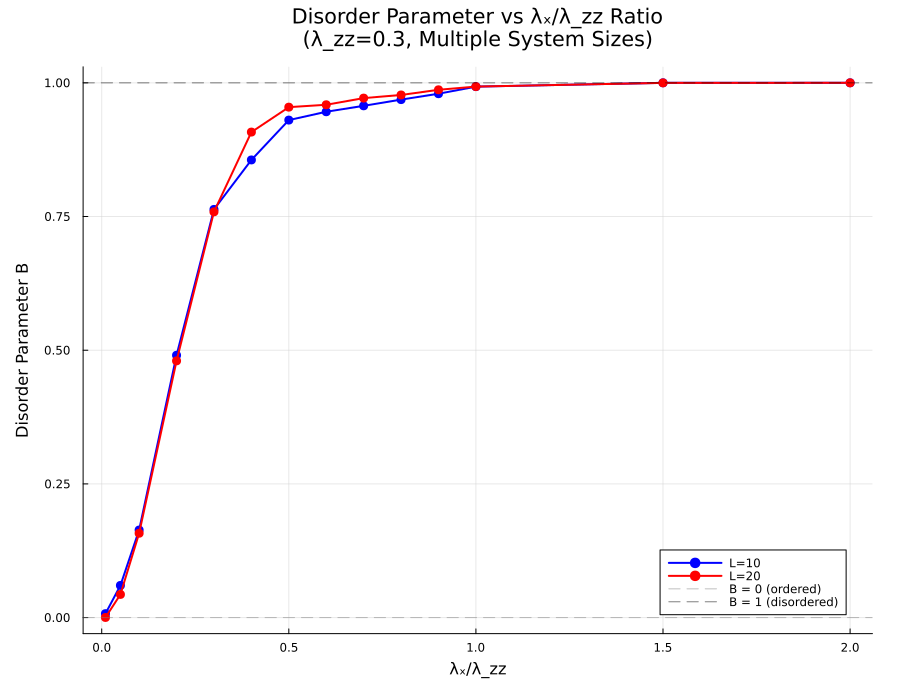

In [11]:
# Display the Disorder Parameter Plot
display(plot1)

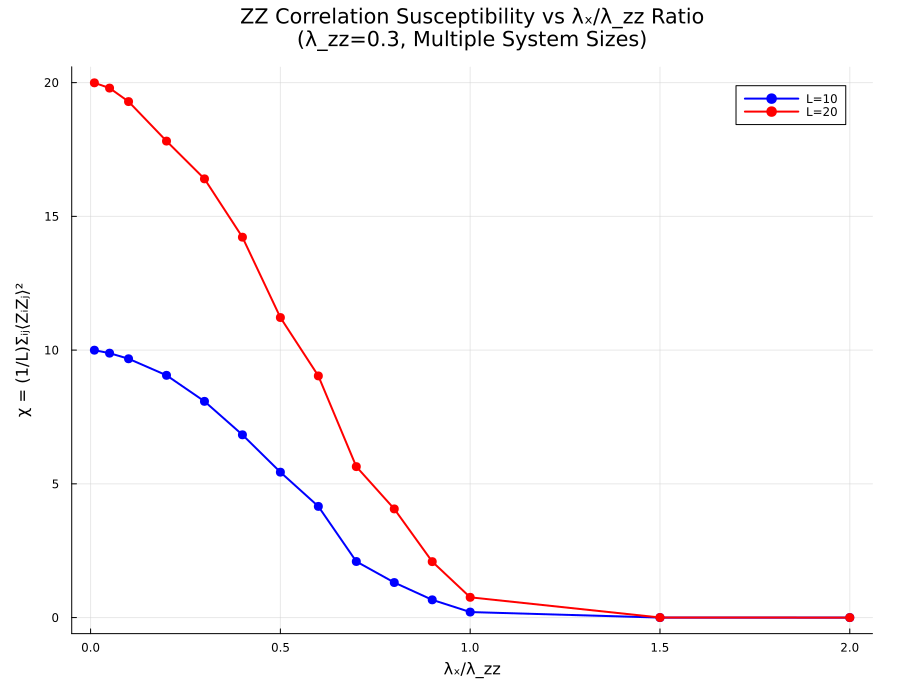

In [12]:
# Display the Chi Susceptibility Plot
display(plot2)